-------------------------------------------------------------

<font size="6"> Monitor My Lockdown Using Seismic Vibration </font>

-------------------------------------------------------------

### Project Website : http://monitormylockdown.com/

-------------------------------------------------------------


#### By Artash Nath

#### Co-Founder, https://hotpoprobot.com/

#### Twitter https://twitter.com/wonrobot

-------------------------------------------------------------

-------------------------------------

## Part 2 : Analyzing Downloaded Seismic Data

-------------------------------------

In the First Notebook, the process for simply downloading the MSEED Files for the specified city were shown.

In this notebook, the process for loading, frequency-analysis, and making sense of this Data is explained.

-------------------------------------

In [1]:
# If you have not already, install the required libraries for this code.


# For mathematical operations on our data
!pip install numpy  

# Track the time-progress of some steps in the code as Some parts may take a considerable amount of time
!pip install tqdm   

# To Download the MSEED Seismic Files from the data source (https://www.iris.edu/)
!pip install obspy  


In [1]:
DATA_STORAGE_PATH = r'E:\DATA'

-------------------------------------
## 1. Import Required Libararies
-------------------------------------

In [2]:
# Importing Required Libraries

import datetime # To iterate and manage the dates we want to download our data over
import os # Help with file directories
import csv # Writing CSV files to temporarily store some Data
import matplotlib.pyplot as plt # Displaying Graphs
import matplotlib.ticker as ticker

#Data Handling
import numpy as np
import pandas as pd
import csv

#Obspy is a Python libary to help download and process seismic data
from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client

# To break data into different frequencies
from scipy import signal

# Track program progress
from tqdm.notebook import tqdm
import threading

# Warnings can be annoying- you can remove them with the following peice of code
import warnings
warnings.filterwarnings("ignore")

-------------------------------------
## Station Information
-------------------------------------

This should be the same station information that was put into the "1. Download Seismic Data.ipynb" file

In [3]:
start = UTCDateTime("2019-12-01")  
end = UTCDateTime("2021-4-20")


# Study Period - From Jan 2019 to Yesterday
start = UTCDateTime("2019-12-01")  
end = UTCDateTime("2021-2-4") # This can be changed to at most yesterday's date

# Computing List of Dates To Analyze
datelist = pd.date_range(start.datetime, end.datetime, freq="D")



# Station Information that stays the same no matter what station you pick
location = "--" 
channel = "HHZ"
data_provider = "IRIS"
c = Client(data_provider)

stations = ['TORO'] # This is the station name for the "Toronto" station, you can add as many stations as you want
networks = ['WU'] # Simmilarely, this is TORO's Network Name, you must add the network for each station

-------------------------------------
## 2. Creating Functions
-------------------------------------

In [4]:
# Breaks a sample of raw data into it's frequency bands (1 - 50 Hz)
# We are only able to get up to 50 Hz as the Seismic Data from the stations measure vibrations at 100 Hz
# Returns 2 items- the PPSD, as well as the corresponding frequencies for the PPSD
def PPSD(sequence):
    return signal.welch(sequence, 100)

In [5]:
# PPSD_ARRAY Takes an Entire Day's worth of Data, Breaks it into Chunks of 30 minutes with a 50% overlap
# Then Breaks each chunk into it's frequencies using the PPSD Function Defined in the previous cell
# Then combines chunks for the day into 12 2-hour periods and returns 2 items:
# PPSDs for each 2-hour period, their corresponding frequencies
def PPSD_ARRAY(raw_data):
    
    # a) Breaks the Raw Data into chunks of 30-minutes, with a 15-minute overlap
    
    n = (100) * (60) * 30 # Chunk Size (100 samples/second x 60-seconds/minute x 30-minutes)
    m = (100) * (60) * 15 # Overlap Size (100 samples/second x 60-seconds/minute x 15-minutes)

    chunks = [raw_data[i:i+n] for i in range(0, len(raw_data), n-m)] # Breaks the raw data into the chunks defined by m & n
    
    # b) Calculates the PPSD of each chunk
    ppsd_rows = []
    for c in chunks[:-1]: # Iterates over each chunk 
        c_ppsd = PPSD(c) # Calculates PPSD for the chunk
        ppsd_rows.append(c_ppsd[1]) # Appends Item2 of the PPSD Function (Actual PPSD)
        freq = c_ppsd[0]  # Stores Item2 of the PPSD Function (Corresponding Frequencies of the PPSD)
        
    # Converts both the PPSDs of each chunk, as well as the corresponding frequency list into Arrays
    # (The Corresponding Frequencies stay the same for all chunks as they are all at the same sample rate)
    ppsd_rows = np.array(ppsd_rows)
    freq = np.array(freq)
    
    # C) Combine the day's worth of chunks into 2-hour periods 
    ppsd_rows = ppsd_rows[2:-2] # Removing Unnecesary Extremeties caused by the 50% data overlap
    
    # As we have 30-minute chunks with 15-minute overlaps, there are 96 such chunks in our data
    # Therefore, a 2-hour period would be represented by 8 such chunks
    
    p1 = np.sum(ppsd_rows[:8], axis = 0) # Period 1 : 12 AM --> 2 AM
    p2 = np.sum(ppsd_rows[8:16], axis = 0) # Period 2 : 2 AM --> 4 AM
    p3 = np.sum(ppsd_rows[16:24], axis = 0) # Period 3 : 4 AM --> 6 AM
    p4 = np.sum(ppsd_rows[24:32], axis = 0) # Period 4 : 6 AM --> 8 AM
    p5 = np.sum(ppsd_rows[32:40], axis = 0) # Period 5 : 8 AM --> 10 AM
    p6 = np.sum(ppsd_rows[40:48], axis = 0) # Period 6 : 10 AM --> 12 PM
    p7 = np.sum(ppsd_rows[48:56], axis = 0) # Period 7 : 12 PM --> 2 PM
    p8 = np.sum(ppsd_rows[56:64], axis = 0) # Period 8 : 2 PM --> 4 PM
    p9 = np.sum(ppsd_rows[64:72], axis = 0) # Period 9 : 4 PM --> 6 PM
    p10 = np.sum(ppsd_rows[72:80], axis = 0) # Period 10 : 6 PM --> 8 PM
    p11 = np.sum(ppsd_rows[80:88], axis = 0) # Period 11 : 8 PM --> 10 PM
    p12 = np.sum(ppsd_rows[88:96], axis = 0) # Period 11 : 10 PM --> 12 AM
    
    # Returns the PPSDs for Each 2-hour period in the day, as well as the corresponding frequencies for the PPSDs
    return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12], freq

In [6]:
def get_frequency_analysis(STATION, READINGS):
    print("RUNNING TASK ", STATION)
    DIR = os.path.join(DATA_STORAGE_PATH, STATION)
    for day in tqdm(datelist):
        fn = day.strftime(STATION + "-%Y-%m-%d.mseed")
        fn = os.path.join(DIR, fn)
        st = read(fn)
        
        data = np.array(st[0].data)

        pxs = PPSD_ARRAY(data)
        freq = pxs[1]
        for p in pxs[0]:
            READINGS.append(p)

In [8]:
# You Must make a list for each city you are analyzing
toronto_readings = []
# examplecity_readings = []

all_city_lists = [toronto_readings] # You must add all other city lists to this list


for station, city_list in zip(stations, all_city_lists):
    get_frequency_analysis(station, city_list)

RUNNING TASK  TORO


KeyboardInterrupt: 

OSError: exception: access violation writing 0x0000000000000000

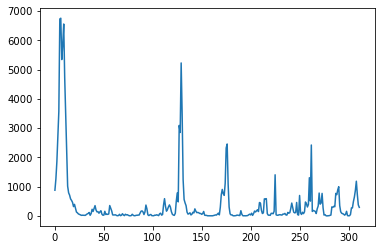

In [17]:
plt.plot(np.array(toronto_readings)[:,100])